# Pré-processamento

In [31]:
# encoding: utf-8
# encoding: iso-8859-1
# encoding: win-1252

import pandas as pd
import csv
from datetime import datetime
from dateutil import parser
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt # Matplot is a common Python lib for plotting
%matplotlib inline
import seaborn as sns # Seaborn is a great tool for data analysis graphs


In [2]:
datasetInFrame = pd.read_csv("output-pleasure-arousal-labeled.csv", sep="|", encoding="ISO-8859-1",quoting=csv.QUOTE_ALL)

In [3]:
#datasetInFrame.describe()
datasetInFrame.head()

,id,txt,val,int,cit,data,dia
0,line_fdl,"Tô tão pensativa ultimamente, nn tô me sentind...",3,3,"Rio de Janeiro, Brasil",10/27/2017 0:17:49,6
1,line_fdl,Guilherme só aparece aqui em casa p fazer barb...,5,4,"Rio de Janeiro, Brasil",10/26/2017 20:47:35,5
2,line_fdl,Amo cheiro de café pela manhã.. ???,5,4,"Rio de Janeiro, Brasil",10/26/2017 9:45:33,5
3,line_fdl,Tô meio aérea,4,2,"Rio de Janeiro, Brasil",10/26/2017 1:24:55,5
4,line_fdl,"Tô mega cansada nn sei que cançaso é esse, só ...",2,4,"Rio de Janeiro, Brasil",10/26/2017 0:56:21,5


## Verificando a distribuição das Classes:
Intensidade: 1 a 7
Valência: 1 a 7

In [4]:
totalIntensityClasses = {}

for i in range(1,8):
    totalIntensityClasses[i] = datasetInFrame[datasetInFrame.int == i]["txt"].count()
totalIntensityClasses

{1: 129, 2: 218, 3: 243, 4: 273, 5: 229, 6: 156, 7: 70}

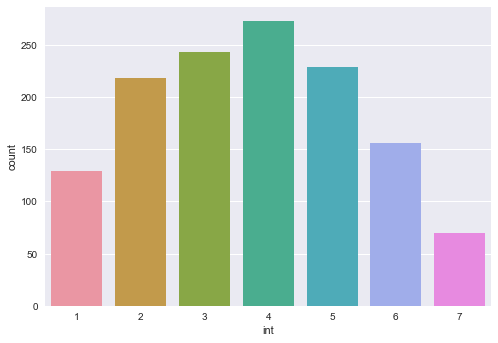

In [5]:
sns.countplot(x='int', data=datasetInFrame)

In [6]:
totalValencyClasses = {}

for i in range(1,8):
    totalValencyClasses[i] = datasetInFrame[datasetInFrame.val == i]["txt"].count()
totalValencyClasses

{1: 49, 2: 189, 3: 316, 4: 225, 5: 413, 6: 106, 7: 20}

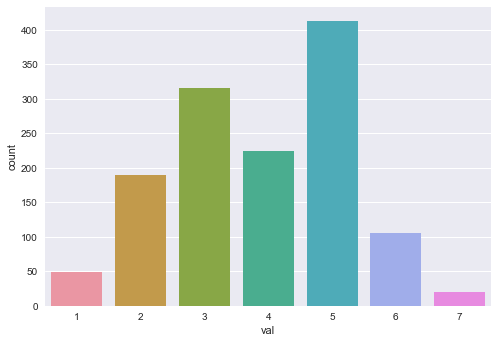

In [7]:
sns.countplot(x='val', data=datasetInFrame)

## Separando data e hora

In [8]:
dateTime = datasetInFrame["data"].apply(lambda  x: x.split(' '))
date = dateTime.apply(lambda x: x[0])
time = dateTime.apply(lambda x: x[1])
datasetInFrame["date"] = date
datasetInFrame["time"] = time
del datasetInFrame["data"]
####
#format = '%m/%d/%Y %H:%M:%S'
#datetime.strptime("10/27/2017 0:17:49", format)

datetime.datetime(2017, 10, 27, 0, 17, 49)

## Substituindo Valores Para Cidade
1. Removendo o País;
2. Substituindo: 
    * Rio de Janeiro = 1 
    * São Paulo = 2

In [9]:
city = datasetInFrame["cit"].apply(lambda x: x.split(','))
datasetInFrame["cit"] = city.apply(lambda x: x[0])

In [10]:
datasetInFrame["cit"] = datasetInFrame["cit"].apply(lambda x: 1 if x == "Rio de Janeiro" else 2)
#datasetInFrame

## Criando *features*
1. isWeekend? [dia 6 após às 19:00, dia 7  e  1 até 19:00 sim 0 não
2. isMad? 1 sim 0 não

In [40]:
def isWeekend(day,hour):
    format = '%H:%M:%S'
    hour = datetime.strptime(hour, format)
    limitWeekend = datetime.strptime("19:00:00", format)
    if (day == 6) and (hour >= limitWeekend):
        return 1
    elif (day == 1) and (hour < limitWeekend):
        return 1
    elif day == 7:
        return 1
    else:
        return 0

datasetInFrame['isWeekend'] = pd.Series(np.zeros(len(datasetInFrame)), index=datasetInFrame.index)

for index, row in datasetInFrame.iterrows():
    datasetInFrame.loc[index,"isWeekend"] = isWeekend(row["dia"],row["time"])
datasetInFrame.head()

,id,txt,val,int,cit,dia,date,time,isWeekend
0,line_fdl,"Tô tão pensativa ultimamente, nn tô me sentind...",3,3,1,6,10/27/2017,0:17:49,0.0
1,line_fdl,Guilherme só aparece aqui em casa p fazer barb...,5,4,1,5,10/26/2017,20:47:35,0.0
2,line_fdl,Amo cheiro de café pela manhã.. ???,5,4,1,5,10/26/2017,9:45:33,0.0
3,line_fdl,Tô meio aérea,4,2,1,5,10/26/2017,1:24:55,0.0
4,line_fdl,"Tô mega cansada nn sei que cançaso é esse, só ...",2,4,1,5,10/26/2017,0:56:21,0.0


In [57]:
def isMad(hour):
    format = '%H:%M:%S'
    hour = datetime.strptime(hour, format)
    initLimit = datetime.strptime("23:00:00", format)
    endLimit = datetime.strptime("05:00:00", format)
    
    if (hour >= initLimit) or (hour < endLimit):
        return 1
    else:
        return 0

    
datasetInFrame['isMad'] = pd.Series(np.zeros(len(datasetInFrame)), index=datasetInFrame.index)

for index, row in datasetInFrame.iterrows():
    datasetInFrame.loc[index,"isMad"] = isMad(row["time"])
datasetInFrame.head()

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
0,line_fdl,"Tô tão pensativa ultimamente, nn tô me sentind...",3,3,1,6,10/27/2017,0:17:49,0.0,1.0
1,line_fdl,Guilherme só aparece aqui em casa p fazer barb...,5,4,1,5,10/26/2017,20:47:35,0.0,0.0
2,line_fdl,Amo cheiro de café pela manhã.. ???,5,4,1,5,10/26/2017,9:45:33,0.0,0.0
3,line_fdl,Tô meio aérea,4,2,1,5,10/26/2017,1:24:55,0.0,1.0
4,line_fdl,"Tô mega cansada nn sei que cançaso é esse, só ...",2,4,1,5,10/26/2017,0:56:21,0.0,1.0


## Removendo colunas

Colunas removidas: date, time, cit e int

## Balanceando os dados

In [70]:
balancedDataset = pd.DataFrame()
limitSamples = 100
for i in datasetInFrame['val'].unique():
    balancedDataset = balancedDataset.append(datasetInFrame[datasetInFrame['val'] == i].iloc[:limitSamples],ignore_index=True)
    
balancedDataset

,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
0,line_fdl,"Tô tão pensativa ultimamente, nn tô me sentind...",3,3,1,6,10/27/2017,0:17:49,0.0,1.0
1,line_fdl,Joana fez eu me arrumar atoa affff cr,3,5,1,4,10/25/2017,0:45:39,0.0,1.0
2,line_fdl,Tô tão sem paciência sem.or,3,5,1,6,10/20/2017,23:25:23,1.0,1.0
3,line_fdl,Até gosto de calor mas tá de mais mds scrr,3,4,1,5,10/19/2017,22:36:52,0.0,0.0
4,line_fdl,Tô com uma dorzinha d cabeça q ta me dx enjoad...,3,4,1,4,10/18/2017,22:33:22,0.0,0.0
5,line_fdl,Fico puta quando tô ouvindo msc no rádio e com...,3,5,1,4,10/18/2017,21:08:26,0.0,0.0
6,line_fdl,"Perco a fome quando tô preocupada que saco,",3,5,1,4,10/18/2017,0:53:56,0.0,1.0
7,brunaarvi,meu sonho de princesa um maine coon pra chamar...,3,5,1,4,10/25/2017,17:06:03,0.0,0.0
8,brunaarvi,ajudo geral nessa porra mas não vem querer tir...,3,6,1,3,10/24/2017,13:58:44,0.0,0.0
9,brunaarvi,acordar cedo nesse frio é maior sacanagem,3,3,1,3,10/24/2017,8:38:37,0.0,0.0


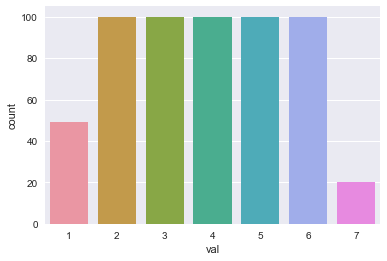

In [77]:
sns.countplot(x='val', data=balancedDataset)

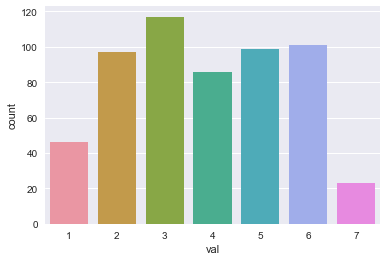

In [76]:
df = balancedDataset.sample(len(balancedDataset), replace=True)git
sns.countplot(x='val', data=df)


## Separando os nomes

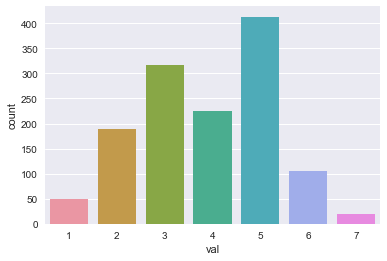

In [65]:
sns.countplot(x='val', data=datasetInFrame)

In [79]:
balancedDataset.head()


,id,txt,val,int,cit,dia,date,time,isWeekend,isMad
0,line_fdl,"Tô tão pensativa ultimamente, nn tô me sentind...",3,3,1,6,10/27/2017,0:17:49,0.0,1.0
1,line_fdl,Joana fez eu me arrumar atoa affff cr,3,5,1,4,10/25/2017,0:45:39,0.0,1.0
2,line_fdl,Tô tão sem paciência sem.or,3,5,1,6,10/20/2017,23:25:23,1.0,1.0
3,line_fdl,Até gosto de calor mas tá de mais mds scrr,3,4,1,5,10/19/2017,22:36:52,0.0,0.0
4,line_fdl,Tô com uma dorzinha d cabeça q ta me dx enjoad...,3,4,1,4,10/18/2017,22:33:22,0.0,0.0


## Adicionando *features* de texto
1. Bag of words

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z]\w+\b",stop_words='portuguese',lowercase=True)
data = []
for i,row in totalTrain.iterrows():
    data.append(row['txt'].strip())
data

['Tô tão pensativa ultimamente, nn tô me sentindo bem ??',
 'Guilherme só aparece aqui em casa p fazer barba e sobrancelha, incrível q primo uor kk',
 'Amo cheiro de café pela manhã.. ???',
 'Tô meio aérea',
 'Tô mega cansada nn sei que cançaso é esse, só quero minha cama..',
 'Mal comecei a ler o livro "O que realmente importa?" e já estou amando ????',
 'Joana fez eu me arrumar atoa affff cr',
 'Hoje ainda é terça mas já tô pensando lá na sextaa, preciso desenrolar um role..',
 'Detesto ser mt perfeccionista..',
 'Tpm é uma coisa mt bosta mxm, faz meu humor mudar td hr',
 'Que preguiça de levantar da cama com esse tempinho aaaai',
 'Tô com uma vontade louca de comer tapioca com leite condensado, hmmmm..',
 'Comprei meu brinquedinho novo nn vejo a hr de fazer usar, fazer uns cortes amanhã ????',
 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA ??',
 'Minhas conversas com Anderson é só textão misericórdia nn sei como ele me aguenta KK',
 'Povo sempre acha que eu tô doidona nos role por nn parar de danç

## Removendo caracteres especiais

In [75]:
sentences = [ str(sentence).lower().replace("'","").replace(".","").replace(",","").replace('"',"").replace("?","") for sentence in datasetInFrame["txt"]]


## Tokenizing as sentenças

In [76]:
sentencesWithTokens = [nltk.word_tokenize(sentence.lower()) for sentence in sentences]

## Removendo StopWords

In [77]:
stop_words = stopwords.words('portuguese')
sentencesWithoutStopWords = [word for word in sentencesWithTokens if word not in stop_words]
sentencesWithoutStopWords = []
#Navegando no conjunto de dados
for row in sentencesWithTokens:
    sentence = ""
    for word in row:
        if not word in stop_words:
            sentence = sentence + " "+ str(word)
    sentencesWithoutStopWords.append(sentence)
sentencesWithoutStopWords

[' tô tão pensativa ultimamente nn tô sentindo bem',
 ' guilherme aparece aqui casa p fazer barba sobrancelha incrível q primo uor kk',
 ' amo cheiro café manhã',
 ' tô meio aérea',
 ' tô mega cansada nn sei cançaso é quero cama',
 ' mal comecei ler livro realmente importa amando',
 ' joana fez arrumar atoa affff cr',
 ' hoje ainda é terça tô pensando lá sextaa preciso desenrolar role',
 ' detesto ser mt perfeccionista',
 ' tpm é coisa mt bosta mxm faz humor mudar td hr',
 ' preguiça levantar cama tempinho aaaai',
 ' tô vontade louca comer tapioca leite condensado hmmmm',
 ' comprei brinquedinho novo nn vejo hr fazer usar fazer uns cortes amanhã',
 ' aaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 ' conversas anderson é textão misericórdia nn sei aguenta kk',
 ' povo sempre acha tô doidona role nn parar dança min gosto d bbr',
 ' jô parámos festa cleyton literalmente',
 ' sdds sair p sambar tô precisando',
 ' encontrei jonathan vindo p casa ta tão difefente mó sdds',
 ' cheguei casa agr rolando mó ch

# Treinamento do classificador

In [17]:
import sklearn
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.lines as mlines
import numpy as np

## Separação do dataset
Treino em treino e teste, respectivamente, 65% (856) e 35% (462)

In [18]:
#Separação dos targets
train = []
trainTarget = []

totalTrain = datasetInFrame.iloc[0:856]
trainTarget = totalTrain["val"].values
del totalTrain["int"]
del totalTrain["val"]
train = totalTrain.values
print("TREINO: \nTamanho Vetor de Features: ", len(train),"\nTamanho Vetor de Label: ", len(trainTarget))

TREINO: 
Tamanho Vetor de Features:  856 
Tamanho Vetor de Label:  856


In [19]:
#Separação dos targets
test = []
testTarget = []

totalTest = datasetInFrame.iloc[857:1318]
testTarget = totalTest["val"].values
del totalTest["int"]
del totalTest["val"]
test = totalTest.values
print("TESTE:\nTamanho Vetor de Features: ", len(test),"\nTamanho Vetor de Label: ", len(testTarget))

TESTE:
Tamanho Vetor de Features:  461 
Tamanho Vetor de Label:  461


['Tô tão pensativa ultimamente, nn tô me sentindo bem ??',
 'Guilherme só aparece aqui em casa p fazer barba e sobrancelha, incrível q primo uor kk',
 'Amo cheiro de café pela manhã.. ???',
 'Tô meio aérea',
 'Tô mega cansada nn sei que cançaso é esse, só quero minha cama..',
 'Mal comecei a ler o livro "O que realmente importa?" e já estou amando ????',
 'Joana fez eu me arrumar atoa affff cr',
 'Hoje ainda é terça mas já tô pensando lá na sextaa, preciso desenrolar um role..',
 'Detesto ser mt perfeccionista..',
 'Tpm é uma coisa mt bosta mxm, faz meu humor mudar td hr',
 'Que preguiça de levantar da cama com esse tempinho aaaai',
 'Tô com uma vontade louca de comer tapioca com leite condensado, hmmmm..',
 'Comprei meu brinquedinho novo nn vejo a hr de fazer usar, fazer uns cortes amanhã ????',
 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA ??',
 'Minhas conversas com Anderson é só textão misericórdia nn sei como ele me aguenta KK',
 'Povo sempre acha que eu tô doidona nos role por nn parar de danç

In [85]:
classifier = svm.SVC(kernel='rbf',gamma=0.001, C=100.)

In [ ]:
## Todos os registros
classifier.fit(sentencesWithoutStopWords, datasetInFrame["val"].values)